<a id=top-page></a>
# `pykitPIV` demo: Learn to find sources and sinks in a 2D PIV experiment using reinforcement learning

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>

</ol>
<p></p>
</div>
<br>

***

In [232]:
from pykitPIV.ml import PIVEnv, CameraAgent, Rewards, Cues
from pykitPIV.flowfield import compute_q_criterion
from pykitPIV import ParticleSpecs, FlowFieldSpecs, MotionSpecs, ImageSpecs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cmcrameri.cm as cmc
import numpy as np
import onnxruntime
import tensorflow as tf
import torch
import sys, os
import time

***

## Initializations

### Prepare specifications for pykitPIV parameters

In [71]:
particle_spec = ParticleSpecs(diameters=(1, 1),
                              distances=(2, 2),
                              densities=(0.4, 0.4),
                              diameter_std=0,
                              seeding_mode='random')

print(particle_spec)

ParticleSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
diameters=(1, 1),
distances=(2, 2),
densities=(0.4, 0.4),
diameter_std=0,
seeding_mode='random',
random_seed=None)


In [72]:
flowfield_spec = FlowFieldSpecs(size=(100, 200),
                                flowfield_type='random smooth',
                                gaussian_filters=(10, 10),
                                n_gaussian_filter_iter=3,
                                displacement=(2, 2))

print(flowfield_spec)

FlowFieldSpecs(n_images=1,
size=(100, 200),
size_buffer=10,
random_seed=None,
flowfield_type='random smooth',
gaussian_filters=(10, 10),
n_gaussian_filter_iter=3,
displacement=(2, 2),
apply_SLM=False,
integral_time_scale=1,
sigma=1,
n_stochastic_particles=1000000,
n_iterations=100)


In [73]:
motion_spec = MotionSpecs(n_steps=10,
                          time_separation=1,
                          particle_loss=(0, 0),
                          particle_gain=(0, 0))

print(motion_spec)

MotionSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
n_steps=10,
time_separation=1,
particle_loss=(0, 0),
particle_gain=(0, 0))


In [74]:
image_spec = ImageSpecs(exposures=(0.98, 0.98),
                        maximum_intensity=2**16-1,
                        laser_beam_thickness=1,
                        laser_over_exposure=1,
                        laser_beam_shape=0.95,
                        alpha=1/8,
                        clip_intensities=True,
                        normalize_intensities=False)

print(image_spec)

ImageSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
exposures=(0.98, 0.98),
maximum_intensity=65535,
laser_beam_thickness=1,
laser_over_exposure=1,
laser_beam_shape=0.95,
alpha=0.125,
clip_intensities=True,
normalize_intensities=False)


### Prepare the CNN-based inference model for PIV images:

In [6]:
class ONNXmodel:
    
    def __init__(self,
                 onnx_file_path):
        
        self.name = "ONNX"
        self.providers = ['CPUExecutionProvider']
        self.session = onnxruntime.InferenceSession(onnx_file_path, 
                                                    None,
                                                    providers=self.providers)

        self.input_name = self.session.get_inputs()[0].name  
        print('Input Name:', self.input_name)   
 
    def inference(self, x):
        
        output = self.session.run([], {self.input_name:x/np.max(x)})[0] 
      
        return output

    def empty(self):
        
         with torch.no_grad():
            torch.cuda.empty_cache()

In [ ]:
model_file = '../Lima_L4_PAD_SR2_dyn.onnx'
print("model:", model_file, '  exist:', os.path.exists(model_file))

In [ ]:
lima_inference_model = ONNXmodel(model_file)

***

## Create the RL environment

Define the cues that the RL agent effectively senses and learns from:

In [7]:
cues_obj = Cues()
cues_function = cues_obj.sampled_vectors

Initialize the `Gymnasium` environment:

In [8]:
env = PIVEnv(interrogation_window_size=(60,60),
             interrogation_window_size_buffer=5,
             cues_function=cues_function,
             particle_spec=particle_spec,
             motion_spec=motion_spec,
             image_spec=image_spec,
             flowfield_spec=flowfield_spec,
             inference_model=None,
             random_seed=None)

Reset the environment to prepare its intial state:

In [9]:
camera_position, cues = env.reset()

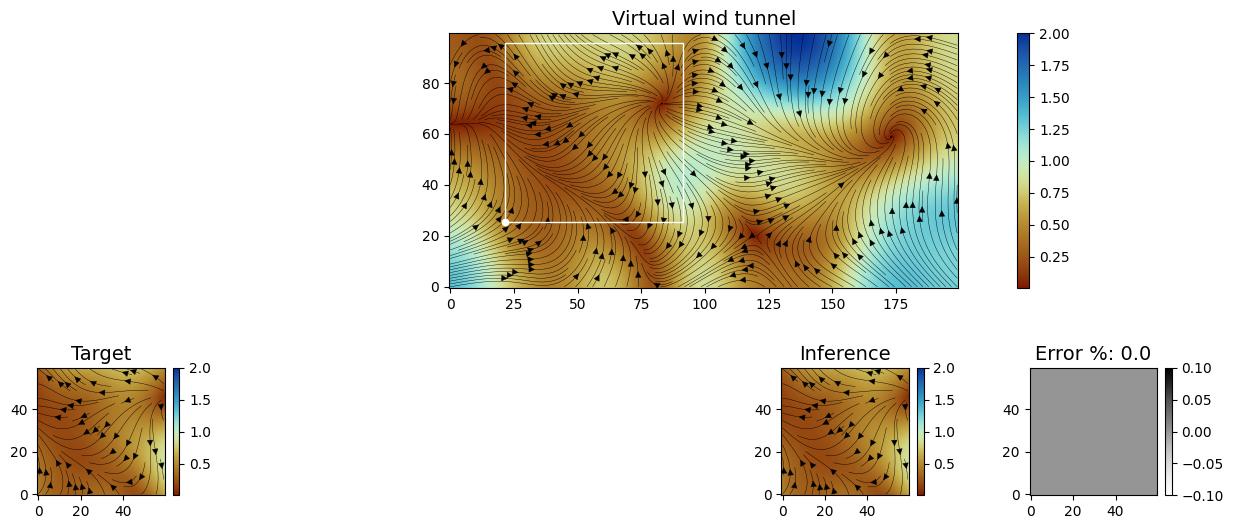

In [10]:
plt = env.render(camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=3,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(15,6), 
                 filename=None)

***

## Create and train the RL agent

In [96]:
n_episodes = 1
n_iterations = 20
random_seed = 0
verbose = False
iter_count = 0
epsilon_start = 0.7
discount_factor=0.95
batch_size = 256
memory_size = 10000
initial_learning_rate = 0.0001
alpha_lr = 0.0001
n_epochs = 100
n_decay_steps = int(n_episodes/1.5)

In [40]:
def epsilon_exp_decay(epsilon_start, iter_count, n=100):
    return epsilon_start/np.exp(iter_count/(n))

Define the Q-network:

In [41]:
class QNetwork(tf.keras.Model):
    
    def __init__(self, n_actions):
        
        super(QNetwork, self).__init__()
        
        self.dense1 = tf.keras.layers.Dense(30, activation='linear', kernel_initializer=tf.keras.initializers.Ones)
        self.dense2 = tf.keras.layers.Dense(20, activation='linear', kernel_initializer=tf.keras.initializers.Ones)
        self.dense3 = tf.keras.layers.Dense(10, activation='linear', kernel_initializer=tf.keras.initializers.Ones)
        self.output_layer = tf.keras.layers.Dense(n_actions, activation='linear', kernel_initializer=tf.keras.initializers.Ones)

    def call(self, state):
        
        x = self.dense1(state)
        x = self.dense2(x)
        x = self.dense3(x)
        
        return self.output_layer(x)

Initialize the camera agent:

In [42]:
ca = CameraAgent(env=env,
                 target_q_network=QNetwork(env.n_actions),
                 selected_q_network=QNetwork(env.n_actions),
                 memory_size=memory_size,
                 batch_size=batch_size,
                 n_epochs=n_epochs,
                 learning_rate=initial_learning_rate,
                 optimizer='RMSprop',
                 discount_factor=discount_factor)

The uploaded environment has 5 actions.


Define the cosine learning rate decay:

In [43]:
def decayed_learning_rate(step, initial_learning_rate, alpha, n_epochs, decay_steps):
    
    step = np.min([step, decay_steps])
    cosine_decay = 0.5 * (1 + np.cos(np.pi * step / decay_steps))
    decayed = (1 - alpha) * cosine_decay + alpha
    
    return initial_learning_rate * decayed

Initialize an object of the `Rewards` class to use one of the custom-built reward functions:

In [44]:
rewards = Rewards(verbose=False)
reward_function = rewards.divergence

Define a transformation function for the reward which is appropriate to detecting vortex structures:

In [45]:
def reward_transformation(div):  
    return np.max(np.abs(div))

In [46]:
saved_camera_trajectories_H = np.zeros((n_iterations, n_episodes))
saved_camera_trajectories_W = np.zeros((n_iterations, n_episodes))

In [97]:
total_tic = time.perf_counter()

print('- '*50)

tic = time.perf_counter()

for episode in range(0,n_episodes):

    camera_position, cues = ca.env.reset()
    total_reward = 0
    
    # Exploration probability decreases with training time:
    epsilon = epsilon_exp_decay(epsilon_start, iter_count, n=100)
    print(f'Epsilon: {epsilon:0.3f}')
    
    for i in range(0,n_iterations):

        action = ca.choose_action(cues,
                                  epsilon=epsilon)

        next_camera_position, next_cues, reward = ca.env.step(action,
                                                              reward_function=reward_function,
                                                              reward_transformation=reward_transformation,
                                                              verbose=False)

        ca.remember(cues,
                    action,
                    reward,
                    next_cues)

        cues = next_cues
        total_reward += reward

        saved_camera_trajectories_H[i, episode] = next_camera_position[0]
        saved_camera_trajectories_W[i, episode] = next_camera_position[1]

    iter_count += 1

    # Train the Q-network, (but hold off with training until batch_size of samples is collected):
    if len(ca.memory.buffer) >= batch_size:
    
        # current_lr = decayed_learning_rate(iter_count, initial_learning_rate, alpha_lr, n_epochs, n_decay_steps)
        ca.train(initial_learning_rate)
    
        if (episode+1) % 1 == 0 :
            ca.update_target_network()

    else:
        print('Not training the Q-network yet...')

    if (episode+1) % 10 == 0:
        toc = time.perf_counter()
        print(f"Episode: {episode + 1}, Total Reward: {total_reward:0.5f}")
        print(f'\tThese episodes took: {(toc - tic):0.1f} sec.')
        tic = time.perf_counter()

total_toc = time.perf_counter()
print(f'\n\nTotal time: {(total_toc - total_tic)/60/60:0.2f} h.\n')

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Epsilon: 0.700


Total time: 0.01 h.



Text(0, 0.5, 'MSE loss')

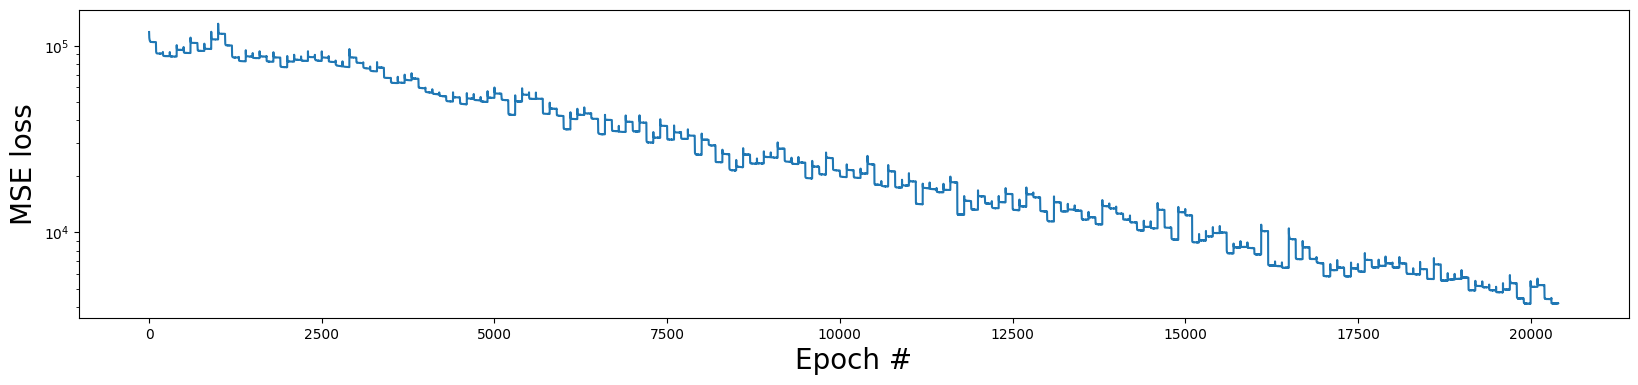

In [98]:
MSE_losses_collected = np.array(ca.MSE_losses).ravel()

plt.figure(figsize=(20,4))
plt.semilogy(MSE_losses_collected)
# plt.ylim([0.00001,10])
plt.xlabel('Epoch #', fontsize=20)
plt.ylabel('MSE loss', fontsize=20)

### Visualize trajectories taken by the agent

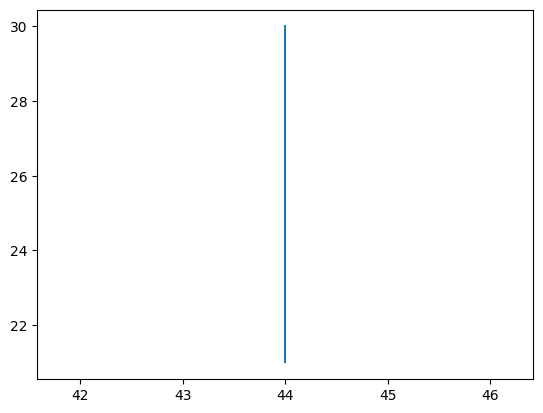

In [99]:
episode = -1
plt.plot(saved_camera_trajectories_W[:,episode], saved_camera_trajectories_H[:,episode])

***

## Test the trained agent on a new environment

In [100]:
particle_spec = ParticleSpecs(diameters=(1, 1),
                              distances=(2, 2),
                              densities=(0.4, 0.4),
                              diameter_std=0,
                              seeding_mode='random')

print(particle_spec)

ParticleSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
diameters=(1, 1),
distances=(2, 2),
densities=(0.4, 0.4),
diameter_std=0,
seeding_mode='random',
random_seed=None)


In [220]:
flowfield_spec = FlowFieldSpecs(size=(200, 600),
                                flowfield_type='random smooth',
                                gaussian_filters=(10, 10),
                                n_gaussian_filter_iter=10,
                                displacement=(2, 2))

print(flowfield_spec)

FlowFieldSpecs(n_images=1,
size=(200, 600),
size_buffer=10,
random_seed=None,
flowfield_type='random smooth',
gaussian_filters=(10, 10),
n_gaussian_filter_iter=10,
displacement=(2, 2),
apply_SLM=False,
integral_time_scale=1,
sigma=1,
n_stochastic_particles=1000000,
n_iterations=100)


In [221]:
motion_spec = MotionSpecs(n_steps=10,
                          time_separation=1,
                          particle_loss=(0, 0),
                          particle_gain=(0, 0))

print(motion_spec)

MotionSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
n_steps=10,
time_separation=1,
particle_loss=(0, 0),
particle_gain=(0, 0))


In [222]:
image_spec = ImageSpecs(exposures=(0.98, 0.98),
                        maximum_intensity=2**16-1,
                        laser_beam_thickness=1,
                        laser_over_exposure=1,
                        laser_beam_shape=0.95,
                        alpha=1/8,
                        clip_intensities=True,
                        normalize_intensities=False)

print(image_spec)

ImageSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
exposures=(0.98, 0.98),
maximum_intensity=65535,
laser_beam_thickness=1,
laser_over_exposure=1,
laser_beam_shape=0.95,
alpha=0.125,
clip_intensities=True,
normalize_intensities=False)


In [223]:
test_env = PIVEnv(interrogation_window_size=(60,60),
                  interrogation_window_size_buffer=10,
                  cues_function=cues_function,
                  particle_spec=particle_spec,
                  motion_spec=motion_spec,
                  image_spec=image_spec,
                  flowfield_spec=flowfield_spec,
                  user_flowfield=None,
                  inference_model=None,
                  random_seed=None)

In [224]:
camera_position, cues = test_env.reset()

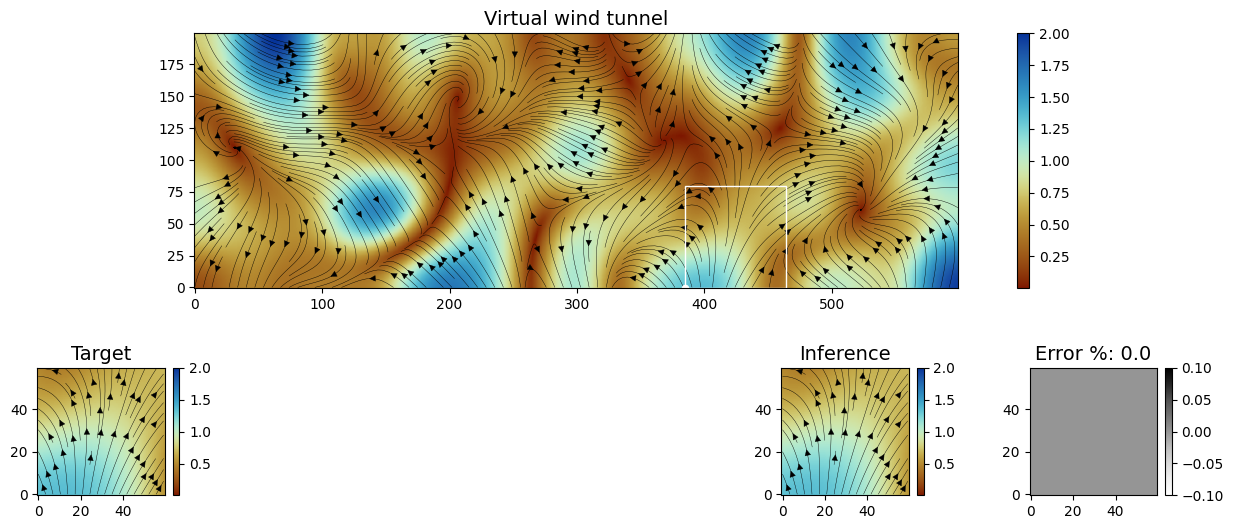

In [225]:
plt = test_env.render(camera_position,
                     c='white',
                     s=20,
                     lw=1,
                     normalize_cbars=True,
                     cmap=cmc.roma,
                     add_streamplot=True,
                     streamplot_density=3,
                     streamplot_color='k',
                     streamplot_linewidth=0.3,
                     figsize=(15,6), 
                     filename=None)

We are going to take a number of steps in the environment:

In [226]:
n_steps = 100

In [227]:
saved_camera_trajectories = np.zeros((n_steps,2))

In [228]:
for i in range(0,n_steps):

    saved_camera_trajectories[i, 0] = camera_position[0]
    saved_camera_trajectories[i, 1] = camera_position[1]

    q_values = ca.target_q_network.predict(cues, verbose=0)

    action = np.argmax(q_values)

    print(test_env.action_to_verbose_direction[action])

    camera_position, cues, reward = test_env.step(action=action,
                                                  reward_function=reward_function,
                                                  reward_transformation=reward_transformation,
                                                  verbose=False)

Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up


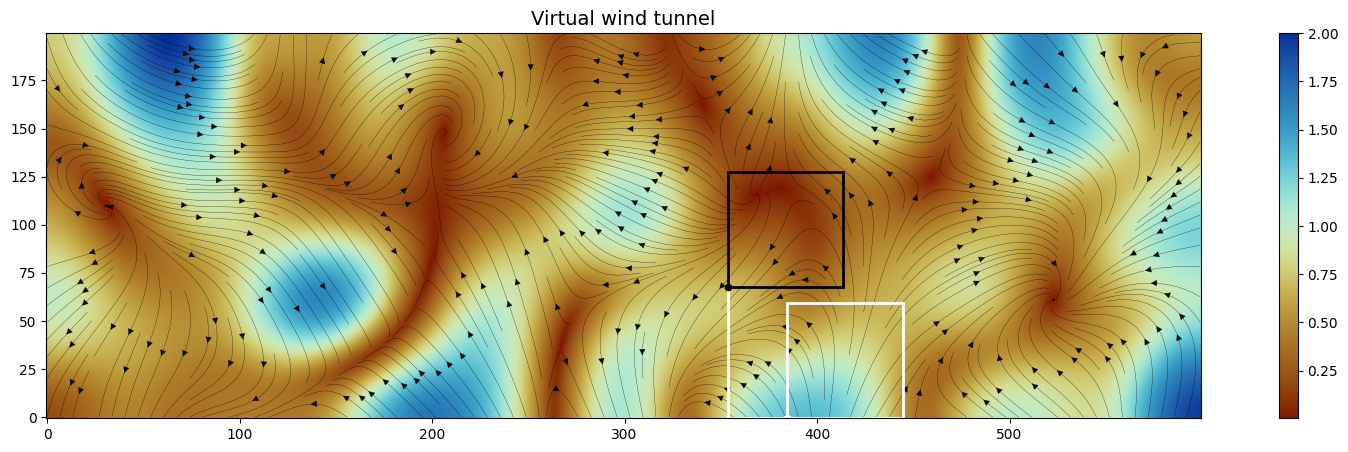

In [241]:
plot_trajectory(test_env.flowfield.velocity_field, 
                saved_camera_trajectories,
                c_path='white',
                c_init='white',
                c_final='black',
                s=20,
                lw=2,
                xlabel=None,
                ylabel=None,
                xticks=True,
                yticks=True,
                cmap=cmc.roma,
                add_streamplot=True,
                streamplot_density=3,
                streamplot_color='k',
                streamplot_linewidth=0.2,
                figsize=(20,5),
                dpi=300,
                filename=None);

In [240]:
def plot_trajectory(displacement_field, 
                    trajectory,
                    c_path='white',
                    c_init='white',
                    c_final='black',
                    s=10,
                    lw=2,
                    xlabel=None,
                    ylabel=None,
                    xticks=True,
                    yticks=True,
                    cmap='viridis',
                    add_streamplot=False,
                    streamplot_density=1,
                    streamplot_color='k',
                    streamplot_linewidth=1,
                    figsize=(10,5),
                    dpi=300,
                    filename=None):

        fontsize = 14

        displacement_field_magnitude = np.sqrt(displacement_field[0, 0, :, :]**2 + displacement_field[0, 1, :, :]**2)

        figure = plt.figure(figsize=figsize)

        ims = plt.imshow(displacement_field_magnitude, cmap=cmap, origin='lower', zorder=0)
        plt.colorbar(ims)

        if add_streamplot:
            X = np.arange(0, displacement_field.shape[3], 1)
            Y = np.arange(0, displacement_field.shape[2], 1)

            plt.streamplot(X, Y,
                           displacement_field[0, 0, :, :],
                           displacement_field[0, 1, :, :],
                           density=streamplot_density,
                           color=streamplot_color,
                           linewidth=streamplot_linewidth,
                           zorder=1)

        plt.plot(trajectory[:,1]-0.5, trajectory[:,0]-0.5, c=c_path, lw=lw, zorder=2)

        # Visualize a rectangle that defines the initial interrogation window:
        plt.scatter(trajectory[0,1]-0.5, trajectory[0,0]-0.5, c=c_init, s=s, zorder=2)

        rect = patches.Rectangle((trajectory[0,1]-0.5, trajectory[0,0]-0.5),
                                 60,
                                 60,
                                 linewidth=lw, edgecolor=c_init, facecolor='none', zorder=2)
        ax = plt.gca()
        ax.add_patch(rect)

        # Visualize a rectangle that defines the final interrogation window:
        plt.scatter(trajectory[-1,1]-0.5, trajectory[-1,0]-0.5, c=c_final, s=s, zorder=2)

        rect = patches.Rectangle((trajectory[-1,1]-0.5, trajectory[-1,0]-0.5),
                                 60,
                                 60,
                                 linewidth=lw, edgecolor=c_final, facecolor='none', zorder=2)
        ax = plt.gca()
        ax.add_patch(rect)
    
        if xlabel is not None:
            plt.xlabel(xlabel)

        if ylabel is not None:
            plt.ylabel(ylabel)

        if not xticks:
            plt.xticks([])

        if not yticks:
            plt.yticks([])

        plt.title('Virtual wind tunnel', fontsize=fontsize)

        if filename is not None:
            plt.savefig(filename, dpi=dpi, bbox_inches='tight')

        return plt

***